# Understanding Large Language Models: Understanding the Fundamentals by Simulated Examples

## Introduction

In this notebook, we will understand how language models predict text by following the complete process of predicting "we love deep learning" word by word. We'll explore four fundamental concepts that make modern language models like ChatGPT work. We will use simulated examples to illustrate these concepts, where functions will use static values instead of actual neural network calculations. We will explore the use real values in later notebooks in this course. The core concepts we will explore are:

1. **Forward Pass**: How models generate predictions
2. **Loss Calculation**: How we measure prediction quality
3. **Backpropagation**: How we identify what needs improvement
4. **Gradient Descent**: How we make those improvements


## Our Vocabulary and Target

We explored what a vocabulary is in the Tokenization notebook in week 1 previously, so we will not cover this topic in detail here.

We'll work with a simple vocabulary to keep things clear and manageable for our learning example.


In [1]:
# Setup our simple vocabulary and target sequence
VOCAB = [
    "<BOS>",
    "we",
    "love",
    "deep",
    "learning",
    "<EOS>",
    "the",
    "is",
    "great",
    "model",
    "hello",
    "world",
]
target_sequence = ["we", "love", "deep", "learning"]

print("VOCABULARY:", VOCAB)
print("TARGET SEQUENCE:", target_sequence)
print("VOCABULARY SIZE:", len(VOCAB))

# Initialize simple model parameters (weights) - these will be updated during training
# In real models, these would be millions or billions of parameters
model_parameters = {
    "layer1_weights": [0.1, -0.3, 0.5, 0.2, -0.1, 0.4, 0.8, -0.2, 0.3, -0.5, 0.7, -0.4],
    "layer2_weights": [0.2, 0.1, -0.4, 0.6, 0.3, -0.2, -0.1, 0.5, -0.3, 0.4, -0.6, 0.1],
    "output_weights": [0.3, -0.1, 0.4, -0.2, 0.5, 0.1, -0.3, 0.2, 0.6, -0.4, 0.1, 0.3],
}

print("\nInitial model parameters (simplified representation):")
print("Layer 1 weights:", len(model_parameters["layer1_weights"]), "parameters")
print("Layer 2 weights:", len(model_parameters["layer2_weights"]), "parameters")
print("Output weights:", len(model_parameters["output_weights"]), "parameters")

VOCABULARY: ['<BOS>', 'we', 'love', 'deep', 'learning', '<EOS>', 'the', 'is', 'great', 'model', 'hello', 'world']
TARGET SEQUENCE: ['we', 'love', 'deep', 'learning']
VOCABULARY SIZE: 12

Initial model parameters (simplified representation):
Layer 1 weights: 12 parameters
Layer 2 weights: 12 parameters
Output weights: 12 parameters


## What Are Logits?

Logits are the raw numerical scores that a language model assigns to every word in its vocabulary when predicting the next word. Think of logits as the model's initial "gut feeling" about how likely each word is to come next, before any normalization.

**Key Properties of Logits:**

- They can be any real number (positive, negative, large, small)
- Higher logits indicate the model thinks a word is more likely
- Lower logits indicate the model thinks a word is less likely
- They are computed by passing the current context through the neural network layers

Let's see what logits look like when our model tries to predict the first word after the beginning-of-sequence token.


In [2]:
def demonstrate_logits():
    # Pre-calculated realistic logit values for predicting first word after <BOS>
    logits_after_bos = {
        "we": 2.1,  # Target word - decent score
        "the": 3.2,  # Highest - most common starter
        "hello": 2.8,  # High - common greeting
        "is": 1.5,  # Medium - possible starter
        "love": -0.5,  # Low - uncommon starter
        "deep": -1.2,  # Lower - rare starter
        "learning": -2.0,  # Very low - very rare starter
        "<EOS>": -10.0,  # Impossible - can't start with end token
    }

    print("Logit scores for predicting first word after <BOS>:")
    print("=" * 50)
    for word, logit in sorted(
        logits_after_bos.items(), key=lambda x: x[1], reverse=True
    ):
        marker = " <- Our target!" if word == "we" else ""
        print(f"{word:10}: {logit:6.1f}{marker}")

    print(
        f"\nNotice how 'the' has the highest logit ({logits_after_bos['the']}) because it's one of the most common ways to start sentences in English."
    )
    print(
        f"Our target word 'we' has a logit of {logits_after_bos['we']}, which is decent but not the highest - the model will need training to improve this!"
    )

    return logits_after_bos


# Run the demonstration
logits_step1 = demonstrate_logits()

Logit scores for predicting first word after <BOS>:
the       :    3.2
hello     :    2.8
we        :    2.1 <- Our target!
is        :    1.5
love      :   -0.5
deep      :   -1.2
learning  :   -2.0
<EOS>     :  -10.0

Notice how 'the' has the highest logit (3.2) because it's one of the most common ways to start sentences in English.
Our target word 'we' has a logit of 2.1, which is decent but not the highest - the model will need training to improve this!


## From Logits to Probabilities: The Softmax Operation

Raw logits are useful for the model internally, but they're not easy for us to interpret. We need to convert them into probabilities - numbers between 0 and 1 that sum to exactly 1.0. This conversion is done using the **softmax function**.

**The Softmax Process:**

1. Calculate e^(logit) for each word (this makes all values positive)
2. Sum all these exponential values
3. Divide each exponential value by the sum

This ensures we get valid probabilities that represent the model's confidence in each possible next word.


In [4]:
import math


def demonstrate_softmax(logits_dict):
    print("SOFTMAX CONVERSION: From Logits to Probabilities")
    print("=" * 55)

    words = list(logits_dict.keys())
    logits = list(logits_dict.values())

    print("STEP 1: Calculate e^(logit) for each word")
    print("-" * 40)
    exp_logits = []
    for word, logit in zip(words, logits):
        exp_val = math.exp(logit)
        exp_logits.append(exp_val)
        print(f"e^({logit:5.1f}) = {exp_val:8.2f}  for '{word}'")

    print(f"\nSTEP 2: Sum all exponential values")
    print("-" * 35)
    total = sum(exp_logits)
    print(f"Total sum = {total:.2f}")

    print(f"\nSTEP 3: Calculate final probabilities")
    print("-" * 38)
    probabilities = {}
    for word, exp_val in zip(words, exp_logits):
        prob = exp_val / total
        probabilities[word] = prob
        marker = " <- Our target!" if word == "we" else ""
        print(f"P({word:8}) = {exp_val:8.2f} / {total:.2f} = {prob:.4f}{marker}")

    print(f"\nVerification: All probabilities sum to {sum(probabilities.values()):.6f}")
    print(
        f"\nKey insight: '{max(logits_dict, key=logits_dict.get)}' had the highest logit"
    )
    print(f"and now has the highest probability ({max(probabilities.values()):.4f})")

    return probabilities


# Convert our logits to probabilities
probabilities_step1 = demonstrate_softmax(logits_step1)

SOFTMAX CONVERSION: From Logits to Probabilities
STEP 1: Calculate e^(logit) for each word
----------------------------------------
e^(  2.1) =     8.17  for 'we'
e^(  3.2) =    24.53  for 'the'
e^(  2.8) =    16.44  for 'hello'
e^(  1.5) =     4.48  for 'is'
e^( -0.5) =     0.61  for 'love'
e^( -1.2) =     0.30  for 'deep'
e^( -2.0) =     0.14  for 'learning'
e^(-10.0) =     0.00  for '<EOS>'

STEP 2: Sum all exponential values
-----------------------------------
Total sum = 54.67

STEP 3: Calculate final probabilities
--------------------------------------
P(we      ) =     8.17 / 54.67 = 0.1494 <- Our target!
P(the     ) =    24.53 / 54.67 = 0.4488
P(hello   ) =    16.44 / 54.67 = 0.3008
P(is      ) =     4.48 / 54.67 = 0.0820
P(love    ) =     0.61 / 54.67 = 0.0111
P(deep    ) =     0.30 / 54.67 = 0.0055
P(learning) =     0.14 / 54.67 = 0.0025
P(<EOS>   ) =     0.00 / 54.67 = 0.0000

Verification: All probabilities sum to 1.000000

Key insight: 'the' had the highest logit
and now h

## Sequential Prediction: How Context Shapes Predictions

Language models don't just predict single words in isolation - they use the entire preceding context to make increasingly informed predictions. As we build up the sequence "we love deep learning," each new word provides more context that helps the model make better predictions for the next word.

Let's observe how the model's logit scores change as we provide more context at each step.


In [2]:
def demonstrate_sequence_prediction():
    print("COMPLETE SEQUENCE PREDICTION: 'we love deep learning'")
    print("=" * 60)

    # Pre-calculated logits for each prediction step showing how context improves predictions
    prediction_steps = [
        {
            "step": 1,
            "context": "<BOS>",
            "target": "we",
            "logits": {
                "we": 2.1,
                "love": -0.5,
                "deep": -1.2,
                "learning": -2.0,
                "the": 3.2,
                "hello": 2.8,
                "is": 1.5,
                "<EOS>": -10.0,
            },
            "explanation": "'we' is a common sentence starter, though 'the' is even more common in general text",
        },
        {
            "step": 2,
            "context": "we",
            "target": "love",
            "logits": {
                "we": -3.0,
                "love": 2.8,
                "deep": -0.5,
                "learning": -1.5,
                "the": 1.2,
                "hello": -5.0,
                "is": 2.1,
                "<EOS>": -8.0,
            },
            "explanation": "After 'we', action words like 'love', 'are', 'have' become much more likely than nouns",
        },
        {
            "step": 3,
            "context": "we love",
            "target": "deep",
            "logits": {
                "we": -5.0,
                "love": -4.0,
                "deep": 1.9,
                "learning": 0.8,
                "the": 0.5,
                "hello": -6.0,
                "is": -2.0,
                "<EOS>": -7.0,
            },
            "explanation": "After 'we love', we expect objects or concepts; 'deep' scores well as it often precedes 'learning'",
        },
        {
            "step": 4,
            "context": "we love deep",
            "target": "learning",
            "logits": {
                "we": -6.0,
                "love": -5.0,
                "deep": -4.0,
                "learning": 3.5,
                "the": -2.0,
                "hello": -8.0,
                "is": -3.0,
                "<EOS>": -6.0,
            },
            "explanation": "'deep learning' is a common collocation - 'learning' becomes very likely after 'deep' in this context",
        },
    ]

    all_step_probabilities = []

    for step_info in prediction_steps:
        print(
            f"\nSTEP {step_info['step']}: Context = '{step_info['context']}' -> Predicting '{step_info['target']}'"
        )
        print("-" * 70)

        # Show top 5 logits
        sorted_logits = sorted(
            step_info["logits"].items(), key=lambda x: x[1], reverse=True
        )
        print("Top 5 logit scores:")
        for i, (word, logit) in enumerate(sorted_logits[:5]):
            marker = " ** TARGET **" if word == step_info["target"] else ""
            print(f"  {i + 1}. {word:10}: {logit:6.1f}{marker}")

        # Calculate probability for target word
        target_logit = step_info["logits"][step_info["target"]]
        exp_values = [math.exp(logit) for logit in step_info["logits"].values()]
        total_exp = sum(exp_values)
        target_prob = math.exp(target_logit) / total_exp
        all_step_probabilities.append(target_prob)

        print(f"\nTarget word '{step_info['target']}' probability: {target_prob:.3f}")
        print(f"Context effect: {step_info['explanation']}")

    return prediction_steps, all_step_probabilities


# Generate predictions for the complete sequence
steps_data, step_probabilities = demonstrate_sequence_prediction()

COMPLETE SEQUENCE PREDICTION: 'we love deep learning'

STEP 1: Context = '<BOS>' -> Predicting 'we'
----------------------------------------------------------------------
Top 5 logit scores:
  1. the       :    3.2
  2. hello     :    2.8
  3. we        :    2.1 ** TARGET **
  4. is        :    1.5
  5. love      :   -0.5

Target word 'we' probability: 0.149
Context effect: 'we' is a common sentence starter, though 'the' is even more common in general text

STEP 2: Context = 'we' -> Predicting 'love'
----------------------------------------------------------------------
Top 5 logit scores:
  1. love      :    2.8 ** TARGET **
  2. is        :    2.1
  3. the       :    1.2
  4. deep      :   -0.5
  5. learning  :   -1.5

Target word 'love' probability: 0.571
Context effect: After 'we', action words like 'love', 'are', 'have' become much more likely than nouns

STEP 3: Context = 'we love' -> Predicting 'deep'
----------------------------------------------------------------------
Top 5 l

## Loss Function: Quantifying Prediction Quality

The **loss function** is how we measure how well our model is performing. Specifically, it measures how "surprised" the model is when it sees the correct answer. The mathematical formulation we use is called **cross-entropy loss** or **log-likelihood loss**.

**Key Concepts:**

- Lower loss = better predictions = less surprise when seeing the correct answer
- Higher loss = worse predictions = more surprise when seeing the correct answer
- Loss is calculated as: Loss = -log(probability of correct word)
- Training aims to minimize the total loss across all predictions

The logarithm has a **useful property** when used in the loss function: it heavily penalizes very low probabilities. If the model assigns a probability of 0.01 to the correct word, the loss is much higher than if it assigns 0.1.


### Understanding what the Training Dataset is and its implications

Before we dive into the mathematical details, it's crucial to understand what the loss function is actually measuring and why it works. The loss function compares our model's predictions against what we call the **"ground truth"** - the training dataset that contains the correct answers.

**Training Dataset as Golden Labels:**

When we train a language model, we provide it with a massive dataset of text (books, articles, websites, etc.). This dataset represents our best approximation of "correct" language use. Each sequence in this dataset serves as:

- **Ground Truth**: The actual words that should come next in real language
- **Golden Labels**: The target answers our model should learn to predict
- **Reference Distribution**: The pattern of language we want our model to internalize

For our example sequence "we love deep learning", this represents a small piece of ground truth data. When we calculate loss, we're measuring how well our model's predictions align with this established pattern of language.

**From Random Weights to Meaningful Predictions:**

Remember our initial model parameters from Section 1? Those weights were randomly initialized:

```python
model_parameters = {
    'layer1_weights': [0.1, -0.3, 0.5, 0.2, -0.1, 0.4, ...],
    'layer2_weights': [0.2, 0.1, -0.4, 0.6, 0.3, -0.2, ...],
    'output_weights': [0.3, -0.1, 0.4, -0.2, 0.5, 0.1, ...]
}
```

These random numbers produce the predictions we saw in previous sections. The model doesn't "know" anything about language initially - its probabilities for predicting "we" (0.149) or "love" (0.571) come purely from these random mathematical operations.

**The Training Objective: Fitting to the Dataset Distribution**

The fundamental goal of training is to **fit the model to the training dataset's distribution**. This means:

1. **Statistical Matching**: Adjust the weights so the model's predicted probabilities match the frequency patterns in the training data
2. **Contextual Learning**: Teach the model that certain word combinations (like "deep learning") are more common than others
3. **Pattern Internalization**: Embed the statistical regularities of human language into the neural network weights

When we minimize the cross-entropy loss across millions of training examples, we're essentially forcing the model to internalize the probability distribution of the training dataset. The model learns that "the" is more common after "<BOS>" because it appears frequently in training data, not because it has any inherent understanding of language.


**Inductive Bias: The Hidden Consequence of Training Data**

This training process creates what we call an **inductive bias** - a set of assumptions and tendencies that the model develops based on its training data. Some also refer to this as the "priors" of the model. This bias manifests in several ways:

1. **Domain Bias**: If trained on academic papers, the model will favor formal language
2. **Cultural Bias**: Training data reflects the cultural context of its sources
3. **Temporal Bias**: Models reflect the time period when their training data was collected
4. **Statistical Bias**: Common patterns in training data become "preferred" by the model

Our model's tendency to predict "the" with high probability after "a BOS token" isn't based on understanding - it's an inductive bias learned from statistical patterns in training data where "the" frequently starts sentences.

**The Philosophical Question of Language Modeling:**

We use human-written text to train models to predict human-like text. The model doesn't learn "language" in an abstract sense explicitly - it learns to mimic the specific patterns present in its training distribution. This is why the choice of training data is so critical and why different models can have vastly different behaviors based on their training datasets.

The loss function, therefore, isn't just measuring prediction accuracy - it's measuring how well the model has absorbed and can reproduce the inductive biases present in its training data.


### The Mathematical Foundation: Next Token Prediction Loss

Now let's dive deep into the precise mathematical formulation used in Large Language Models. The loss function we use is called **Negative Log-Likelihood (NLL)** for **Next Token Prediction (NTP)**.

#### The Complete NLL Formula

For **Next Token Prediction** in Large Language Models, the negative log-likelihood formula is:

**NLL = -∑ᵢ₌₁ⁿ log P(xᵢ | x₁, x₂, ..., xᵢ₋₁; θ)**

**Where:**

- **xᵢ** = the i-th token in the sequence (e.g., "we", "love", "deep", "learning")
- **x₁, x₂, ..., xᵢ₋₁** = all previous tokens providing context
- **θ** = model parameters (our weights from Section 1)
- **n** = sequence length (4 tokens in our example)


#### Breaking Down Each Component of the NLL Formula

**1. Per-Token Probability Computation:**

The probability of each token given its context is computed using softmax:

```
P(xᵢ | context) = softmax(logits)ₓᵢ = exp(zₓᵢ) / ∑ⱼ₌₁ᵛ exp(zⱼ)
```

**Where:**

- **zₓᵢ** = logit score for token xᵢ (like our 2.1 for "we")
- **V** = vocabulary size (12 in our case)
- **j** indexes over entire vocabulary


**2. Averaging Over the Dataset:**

In practice, the NLL loss is computed for every token in every sequence in the dataset. The total loss is then averaged to provide a single scalar value for optimization and monitoring:

**NLL = - (1/N) ∑{i=1}^N log P(xᵢ | context)**

**Where:**

- **N** = total number of tokens (or sequences) in the dataset.
- This averaging ensures the loss is independent of dataset size and comparable across different runs or datasets.


#### Autoregressive Nature

The key insight is that each prediction depends on **all previous tokens**:

- **Step 1**: P("we" | "<BOS>") - no previous content words
- **Step 2**: P("love" | "we") - uses "we" as context
- **Step 3**: P("deep" | "we", "love") - uses both previous tokens
- **Step 4**: P("learning" | "we", "love", "deep") - uses all three previous tokens

This is why our predictions improved with more context in Section 4 - the model had more information to work with.


### Example (from your notebook):

Suppose for the sequence `"we love deep learning"`:

- For **"we"** (after `<BOS>`):  
  P("we" | <BOS>) = 0.149  
  **Loss:**  
  -log(0.149) = 1.904

- For **"love"** (after "we"):  
  P("love" | "we") = 0.571  
  **Loss:**  
  -log(0.571) = 0.560

- For **"deep"** (after "we", "love"):  
  P("deep" | "we", "love") = 0.623  
  **Loss:**  
  -log(0.623) = 0.473


In [2]:
import math

words = ["we", "love", "deep", "learning"]
probs = [0.149, 0.571, 0.623, 0.994]
losses = []

for word, prob in zip(words, probs):
    loss = -math.log(prob)
    losses.append(loss)
    print(f"For '{word}': P = {prob}  ->  Loss = -log({prob}) = {loss:.3f}")

nll = sum(losses) / len(losses) # usually reported as the average of the losses, but could differ sometimes
print(f"\nAverage NLL loss: {nll:.3f}")

For 'we': P = 0.149  ->  Loss = -log(0.149) = 1.904
For 'love': P = 0.571  ->  Loss = -log(0.571) = 0.560
For 'deep': P = 0.623  ->  Loss = -log(0.623) = 0.473
For 'learning': P = 0.994  ->  Loss = -log(0.994) = 0.006

Average NLL loss: 0.736


#### Connection to Perplexity

The loss is often reported as **perplexity**:

```
Perplexity = exp(NLL/n)
```

Lower perplexity indicates better language modeling performance.

These mathematical foundations capture the core training objective of all Large Language Models: **maximize the probability of the correct next token given the context**. Every word prediction in ChatGPT, GPT-4, or any other LLM follows this exact mathematical framework.


In [7]:
import math

probs = [0.149, 0.571, 0.623, 0.994]
losses = [-math.log(p) for p in probs]
nll = sum(losses) / len(losses)
perplexity = math.exp(nll)

print(f"Average NLL loss: {nll:.3f}")
print(f"Perplexity: {perplexity:.3f}")

Average NLL loss: 0.736
Perplexity: 2.087


In [8]:
print("Current total loss:", sum(losses))

Current total loss: 2.943401874883052


In [ ]:
# def demonstrate_cross_entropy_formula():
#     print("CROSS-ENTROPY LOSS FORMULA: Step-by-Step Breakdown")
#     print("=" * 60)

#     print("The cross-entropy loss formula is: Loss = -log(P(correct_word))")
#     print("Let's break this down with a concrete example:\n")

#     # Use a simple toy example
#     print("TOY EXAMPLE: Predicting 'cat' from vocabulary ['dog', 'cat', 'bird']")
#     print("-" * 65)

#     # Toy probabilities for demonstration
#     toy_probabilities = {
#         "dog": 0.2,
#         "cat": 0.6,  # correct word
#         "bird": 0.2,
#     }

#     print("Model predictions (probabilities):")
#     for word, prob in toy_probabilities.items():
#         marker = " <- CORRECT ANSWER" if word == "cat" else ""
#         print(f"  P({word}) = {prob:.1f}{marker}")

#     print(
#         f"\nVerification: {sum(toy_probabilities.values()):.1f} (probabilities sum to 1.0)"
#     )

#     print(f"\nSTEP-BY-STEP LOSS CALCULATION:")
#     print("-" * 35)

#     correct_word = "cat"
#     correct_prob = toy_probabilities[correct_word]

#     print(f"Step 1: Identify the correct word")
#     print(f"        Correct word = '{correct_word}'")

#     print(f"\nStep 2: Find its probability")
#     print(f"        P({correct_word}) = {correct_prob}")

#     print(f"\nStep 3: Take the natural logarithm")
#     log_prob = math.log(correct_prob)
#     print(f"        log(P({correct_word})) = log({correct_prob}) = {log_prob:.4f}")

#     print(f"\nStep 4: Apply the negative sign")
#     loss = -log_prob
#     print(f"        Loss = -log(P({correct_word})) = -({log_prob:.4f}) = {loss:.4f}")

#     print(f"\nFINAL RESULT: Loss = {loss:.4f}")

#     # Show why we use negative log
#     print(f"\n" + "=" * 50)
#     print("WHY NEGATIVE LOGARITHM?")
#     print("=" * 50)

#     prob_examples = [0.9, 0.5, 0.1, 0.01]
#     print("Probability -> log(prob) -> -log(prob) (Loss)")
#     print("-" * 45)

#     for prob in prob_examples:
#         log_val = math.log(prob)
#         loss_val = -log_val
#         quality = (
#             "Excellent"
#             if prob > 0.8
#             else "Good"
#             if prob > 0.4
#             else "Poor"
#             if prob > 0.05
#             else "Terrible"
#         )
#         print(
#             f"   {prob:4.2f}    ->   {log_val:6.2f}   ->   {loss_val:6.2f}  ({quality})"
#         )

#     print(f"\nKey insight: Higher probability -> Lower loss (what we want!)")
#     print(f"            Lower probability -> Higher loss (penalty for bad predictions)")

#     return loss


# def demonstrate_loss_calculation():
#     print("\n" + "=" * 70)
#     print("APPLYING LOSS TO OUR SEQUENCE: 'we love deep learning'")
#     print("=" * 70)

#     print("Now let's calculate loss for each word in our target sequence:")
#     print("Formula: Loss = -log(P(correct_word))")
#     print()

#     words = ["we", "love", "deep", "learning"]
#     total_loss = 0

#     for i, (word, prob) in enumerate(zip(words, step_probabilities)):
#         print(f"STEP {i + 1}: Predicting '{word}'")
#         print("-" * 25)
#         print(f"  Model prediction: P({word}) = {prob:.3f}")
#         print(f"  Take logarithm:   log({prob:.3f}) = {math.log(prob):.4f}")

#         loss = -math.log(prob)
#         total_loss += loss

#         print(f"  Apply negative:   Loss = -({math.log(prob):.4f}) = {loss:.4f}")

#         # Interpret the loss
#         if loss < 0.5:
#             interpretation = "Excellent prediction!"
#         elif loss < 1.0:
#             interpretation = "Good prediction"
#         elif loss < 2.0:
#             interpretation = "Decent prediction"
#         else:
#             interpretation = "Poor prediction - needs improvement"

#         print(f"  Interpretation:   {interpretation}")
#         print()

#     print(f"TOTAL SEQUENCE LOSS:")
#     print("-" * 20)
#     print(f"Sum of all losses = {total_loss:.4f}")
#     print(f"Average per word  = {total_loss / len(words):.4f}")
#     print(
#         f"\nTraining goal: Reduce this total loss by improving individual word predictions!"
#     )

#     return total_loss


# # First demonstrate the formula with toy example
# toy_loss = demonstrate_cross_entropy_formula()

# # Then apply to our actual sequence
# sequence_loss = demonstrate_loss_calculation()

## Backpropagation: Finding What Needs to Change

Now that we understand how to measure our model's performance with the loss function, we need to figure out **which model parameters should be adjusted and by how much** to improve our predictions. This process is called **backpropagation** - it literally means "propagating the error backwards" through the neural network.

**The Central Question:** Our total loss is 2.94. We want to reduce this to improve our predictions. But our model has thousands or millions of parameters. Which ones should we change? And in which direction (increase or decrease)?

**The Answer:** Backpropagation calculates the **gradient** - the mathematical derivative of the loss with respect to each parameter. The gradient tells us:

1. **Direction**: Should we increase or decrease each parameter?
2. **Magnitude**: How much impact will changing each parameter have on the loss?

### The Mathematical Foundation: The Chain Rule

Backpropagation is essentially a systematic application of the **chain rule** from calculus. The chain rule tells us how to compute the derivative of composite functions.

**For our model:** Loss = f(probabilities) = f(softmax(logits)) = f(softmax(neural_network(parameters)))

To find how the loss changes with respect to any parameter, we need to trace the path backwards:

```
∂Loss/∂parameter = ∂Loss/∂probabilities × ∂probabilities/∂logits × ∂logits/∂parameter
```

This "chaining" of derivatives is what gives backpropagation its name - we start from the loss and work backwards through each layer.

For this course, we will not go through the mathematical details of backpropagation. Instead we will use example static values to help us understand the core concept of this.


### Understanding Gradients: Direction and Magnitude

Let's explore what gradients actually represent with concrete examples from our model.

**Key Gradient Properties:**

- **Positive gradient**: Increasing this parameter increases the loss (bad direction)
- **Negative gradient**: Increasing this parameter decreases the loss (good direction)
- **Large gradient magnitude**: This parameter has high impact on loss
- **Small gradient magnitude**: This parameter has low impact on loss

The gradient essentially answers: "If I increase this parameter by a tiny amount, how much will the loss change?"


In [7]:
def demonstrate_gradient_concept():
    print("GRADIENT CONCEPT: What Does a Gradient Tell Us?")
    print("=" * 55)

    print(
        "Imagine we have a simple parameter that affects our model's prediction for 'we'"
    )
    print(
        "Let's call this parameter 'weight_for_we' and see how changing it affects loss"
    )
    print()

    # Current situation
    current_weight = 0.5
    current_prob_we = 0.149  # From our earlier calculation
    current_loss_we = -math.log(current_prob_we)

    print(f"CURRENT SITUATION:")
    print(f"  weight_for_we = {current_weight}")
    print(f"  P(we) = {current_prob_we:.3f}")
    print(f"  Loss for 'we' = -log({current_prob_we:.3f}) = {current_loss_we:.4f}")
    print()

    # Test small changes
    print("TESTING SMALL CHANGES (this is what gradients approximate):")
    print("-" * 58)

    small_change = 0.01
    weight_changes = [-small_change, small_change]

    for i, change in enumerate(weight_changes):
        new_weight = current_weight + change

        # Simulate how the probability might change (simplified)
        # In reality, this involves complex neural network forward pass
        prob_change_factor = 1 + change * 2  # Simplified relationship
        new_prob_we = min(current_prob_we * prob_change_factor, 0.999)
        new_loss_we = -math.log(new_prob_we)

        loss_change = new_loss_we - current_loss_we

        direction = "DECREASE" if change < 0 else "INCREASE"
        print(f"\n{direction} weight by {abs(change):.3f}:")
        print(f"  New weight: {current_weight} -> {new_weight}")
        print(f"  New P(we): {current_prob_we:.3f} -> {new_prob_we:.3f}")
        print(f"  New loss: {current_loss_we:.4f} -> {new_loss_we:.4f}")
        print(f"  Loss change: {loss_change:+.4f}")

        if loss_change < 0:
            print(f"  Result: LOSS DECREASED - this is a GOOD direction!")
        else:
            print(f"  Result: LOSS INCREASED - this is a BAD direction!")

    # Calculate approximate gradient
    print(f"\n" + "=" * 50)
    print("GRADIENT CALCULATION:")
    print("=" * 50)

    # Approximate gradient using finite differences
    loss_at_plus = -math.log(min(current_prob_we * (1 + small_change * 2), 0.999))
    loss_at_minus = -math.log(current_prob_we * (1 - small_change * 2))
    approximate_gradient = (loss_at_plus - loss_at_minus) / (2 * small_change)

    print(f"Approximate gradient = (loss_change) / (weight_change)")
    print(f"                    ≈ {approximate_gradient:.2f}")
    print()

    if approximate_gradient > 0:
        print("INTERPRETATION: Positive gradient means:")
        print("  - Increasing this weight INCREASES loss (bad)")
        print("  - Decreasing this weight DECREASES loss (good)")
        print("  - We should DECREASE this weight during training")
    else:
        print("INTERPRETATION: Negative gradient means:")
        print("  - Increasing this weight DECREASES loss (good)")
        print("  - Decreasing this weight INCREASES loss (bad)")
        print("  - We should INCREASE this weight during training")

    return approximate_gradient


def demonstrate_backprop_process():
    print("\n" + "=" * 70)
    print("BACKPROPAGATION PROCESS: Step-by-Step Through Our Network")
    print("=" * 70)

    print("Let's trace how gradients flow backwards through our model")
    print("for the first prediction: '<BOS>' -> 'we'")
    print()

    # Step 1: Loss gradient
    print("STEP 1: Start with the loss")
    print("-" * 30)
    target_prob = 0.149  # P(we) from our calculation
    loss = -math.log(target_prob)
    print(f"Loss = -log(P(we)) = -log({target_prob:.3f}) = {loss:.4f}")
    print(f"This is our starting point - we want to reduce this loss")
    print()

    # Step 2: Gradient with respect to logits
    print("STEP 2: Gradient with respect to logits")
    print("-" * 42)
    print("For softmax + cross-entropy, the gradient has a beautiful form:")
    print()
    print("∂Loss/∂logit_i = P(word_i) - target_i")
    print()
    print("Where target_i = 1 if word_i is correct, 0 otherwise")
    print()

    # Show gradients for each word in vocabulary
    vocab_subset = ["we", "love", "the", "hello", "is"]
    probs_step1 = {
        "we": 0.149,
        "love": 0.011,
        "the": 0.449,
        "hello": 0.301,
        "is": 0.082,
    }

    print("For our prediction '<BOS>' -> 'we':")
    for word in vocab_subset:
        prob = probs_step1[word]
        target = 1 if word == "we" else 0
        gradient = prob - target

        marker = " <- TARGET WORD" if word == "we" else ""
        print(
            f"  ∂Loss/∂logit_{word:8} = {prob:.3f} - {target} = {gradient:+.3f}{marker}"
        )

    print()
    print("Key insights:")
    print("- Target word 'we': gradient = 0.149 - 1 = -0.851 (NEGATIVE)")
    print("  This means increasing logit_we will DECREASE loss (good!)")
    print("- Other words: positive gradients")
    print("  This means increasing their logits will INCREASE loss (bad!)")

    # Step 3: Gradient flows to earlier layers
    print(f"\nSTEP 3: Gradients flow to network weights")
    print("-" * 40)
    print("The gradients we calculated above now flow backwards to:")
    print("- Output layer weights (that produce logits)")
    print("- Hidden layer weights")
    print("- Input embedding weights")
    print()
    print("Each weight's gradient tells us:")
    print("- How much that weight contributed to the current loss")
    print("- Which direction to adjust it to improve predictions")

    return {"target_logit_gradient": -0.851}


# Run the demonstrations
gradient_example = demonstrate_gradient_concept()
backprop_results = demonstrate_backprop_process()

GRADIENT CONCEPT: What Does a Gradient Tell Us?
Imagine we have a simple parameter that affects our model's prediction for 'we'
Let's call this parameter 'weight_for_we' and see how changing it affects loss

CURRENT SITUATION:
  weight_for_we = 0.5
  P(we) = 0.149
  Loss for 'we' = -log(0.149) = 1.9038

TESTING SMALL CHANGES (this is what gradients approximate):
----------------------------------------------------------

DECREASE weight by 0.010:
  New weight: 0.5 -> 0.49
  New P(we): 0.149 -> 0.146
  New loss: 1.9038 -> 1.9240
  Loss change: +0.0202
  Result: LOSS INCREASED - this is a BAD direction!

INCREASE weight by 0.010:
  New weight: 0.5 -> 0.51
  New P(we): 0.149 -> 0.152
  New loss: 1.9038 -> 1.8840
  Loss change: -0.0198
  Result: LOSS DECREASED - this is a GOOD direction!

GRADIENT CALCULATION:
Approximate gradient = (loss_change) / (weight_change)
                    ≈ -2.00

INTERPRETATION: Negative gradient means:
  - Increasing this weight DECREASES loss (good)
  - Decr

### The Full Backpropagation Picture

Let's put together the complete picture of how backpropagation works in our language model by examining what happens when we process our entire sequence "we love deep learning".

**The Process:**

1. **Forward Pass**: Compute predictions and loss for each word
2. **Backward Pass**: Calculate gradients for each parameter
3. **Accumulate Gradients**: Sum gradients from all prediction steps
4. **Parameter Updates**: Use gradients to improve model weights

This happens for every training example, and the gradients tell us exactly how to adjust our model to make better predictions.


In [9]:
def demonstrate_full_backpropagation():
    print("COMPLETE BACKPROPAGATION: All Four Prediction Steps")
    print("=" * 58)

    # Data from our previous calculations
    sequence_data = [
        {
            "step": 1,
            "context": "<BOS>",
            "target": "we",
            "probability": 0.149,
            "loss": 1.904,
            "logit_gradient": -0.851,  # P(we) - 1 = 0.149 - 1
        },
        {
            "step": 2,
            "context": "we",
            "target": "love",
            "probability": 0.571,
            "loss": 0.560,
            "logit_gradient": -0.429,  # P(love) - 1 = 0.571 - 1
        },
        {
            "step": 3,
            "context": "we love",
            "target": "deep",
            "probability": 0.623,
            "loss": 0.473,
            "logit_gradient": -0.377,  # P(deep) - 1 = 0.623 - 1
        },
        {
            "step": 4,
            "context": "we love deep",
            "target": "learning",
            "probability": 0.994,
            "loss": 0.006,
            "logit_gradient": -0.006,  # P(learning) - 1 = 0.994 - 1
        },
    ]

    print("For each prediction step, backpropagation calculates:")
    print("- How much each parameter contributed to the loss")
    print("- Which direction to adjust each parameter")
    print()

    total_loss = 0

    for data in sequence_data:
        print(f"STEP {data['step']}: '{data['context']}' -> '{data['target']}'")
        print("-" * 50)
        print(f"  Forward pass:  P({data['target']}) = {data['probability']:.3f}")
        print(f"  Loss:          {data['loss']:.4f}")
        print(f"  Logit gradient: {data['logit_gradient']:.3f}")

        # Interpret the gradient
        if abs(data["logit_gradient"]) > 0.5:
            urgency = "High priority"
        elif abs(data["logit_gradient"]) > 0.1:
            urgency = "Medium priority"
        else:
            urgency = "Low priority"

        print(
            f"  Interpretation: {urgency} - adjust weights to boost '{data['target']}'"
        )
        print()

        total_loss += data["loss"]

    print("GRADIENT ACCUMULATION:")
    print("-" * 25)
    print("In a real training step, we would:")
    print("1. Sum up all the gradients from each prediction step")
    print("2. Apply these combined gradients to update model parameters")
    print("3. The model gets slightly better at each prediction")
    print()

    print(f"Total loss across all steps: {total_loss:.4f}")
    print(f"This is what we're trying to minimize through training!")

    # Show how gradients would affect our original parameters
    print(f"\n" + "=" * 60)
    print("IMPACT ON MODEL PARAMETERS:")
    print("=" * 60)

    print("Our original parameters (from Section 1):")
    print("  layer1_weights: [0.1, -0.3, 0.5, 0.2, -0.1, 0.4, ...]")
    print("  layer2_weights: [0.2, 0.1, -0.4, 0.6, 0.3, -0.2, ...]")
    print("  output_weights: [0.3, -0.1, 0.4, -0.2, 0.5, 0.1, ...]")
    print()

    print("After backpropagation, each weight gets a gradient:")
    print("  gradient_layer1: [-0.05, 0.12, -0.08, 0.03, 0.07, -0.15, ...]")
    print("  gradient_layer2: [0.09, -0.04, 0.11, -0.18, 0.06, 0.08, ...]")
    print("  gradient_output: [-0.21, 0.15, -0.12, 0.09, -0.17, 0.11, ...]")
    print()

    print("These gradients tell us:")
    print("- Negative gradient: Increase this weight to reduce loss")
    print("- Positive gradient: Decrease this weight to reduce loss")
    print("- Large magnitude: This weight has high impact")
    print("- Small magnitude: This weight has low impact")

    return sequence_data


def demonstrate_gradient_flow():
    print(f"\n" + "=" * 65)
    print("GRADIENT FLOW: How Information Travels Backwards")
    print("=" * 65)

    print("Think of gradients as 'error signals' that flow backwards:")
    print()

    network_layers = [
        "INPUT: Token embeddings ('<BOS>', 'we', 'love', etc.)",
        "LAYER 1: First transformation (hidden layer)",
        "LAYER 2: Second transformation (hidden layer)",
        "OUTPUT: Logits for each vocabulary word",
        "SOFTMAX: Convert logits to probabilities",
        "LOSS: Compare with target word",
    ]

    print("FORWARD PASS (left to right):")
    print("-" * 35)
    for i, layer in enumerate(network_layers):
        indent = "  " * i
        print(f"{indent}→ {layer}")

    print(f"\nBACKWARD PASS (right to left - gradients flow backwards):")
    print("-" * 60)

    gradient_flow = [
        "LOSS GRADIENT: ∂Loss/∂Loss = 1 (starting point)",
        "SOFTMAX GRADIENT: ∂Loss/∂probabilities",
        "LOGIT GRADIENT: ∂Loss/∂logits (we calculated these!)",
        "OUTPUT GRADIENT: ∂Loss/∂output_weights",
        "LAYER 2 GRADIENT: ∂Loss/∂layer2_weights",
        "LAYER 1 GRADIENT: ∂Loss/∂layer1_weights",
    ]

    for i, gradient in enumerate(reversed(gradient_flow)):
        indent = "  " * i
        print(f"{indent}← {gradient}")

    print(f"\nKey insight: Each layer's gradient depends on the gradients")
    print(f"from all layers that come after it. This is the 'chain rule' in action!")

    return gradient_flow


# Run the demonstrations
sequence_gradients = demonstrate_full_backpropagation()
gradient_flow_info = demonstrate_gradient_flow()

COMPLETE BACKPROPAGATION: All Four Prediction Steps
For each prediction step, backpropagation calculates:
- How much each parameter contributed to the loss
- Which direction to adjust each parameter

STEP 1: '<BOS>' -> 'we'
--------------------------------------------------
  Forward pass:  P(we) = 0.149
  Loss:          1.9040
  Logit gradient: -0.851
  Interpretation: High priority - adjust weights to boost 'we'

STEP 2: 'we' -> 'love'
--------------------------------------------------
  Forward pass:  P(love) = 0.571
  Loss:          0.5600
  Logit gradient: -0.429
  Interpretation: Medium priority - adjust weights to boost 'love'

STEP 3: 'we love' -> 'deep'
--------------------------------------------------
  Forward pass:  P(deep) = 0.623
  Loss:          0.4730
  Logit gradient: -0.377
  Interpretation: Medium priority - adjust weights to boost 'deep'

STEP 4: 'we love deep' -> 'learning'
--------------------------------------------------
  Forward pass:  P(learning) = 0.994
  L

Note: We intentionally kept the mathematical details of backpropagation simple to make it easier to understand. It is highly recommended to deeply understand the mathematical details of backpropagation, through something like Kaparthy's Neural Network Zero-to-Hero course


## Gradient Descent: Making Improvements

Now that we have calculated the gradients that tell us which direction to adjust each parameter, we need to actually make those adjustments. This process is called **gradient descent** - it's the algorithm that uses our gradients to systematically improve the model's parameters.

**The Core Idea:** If a gradient tells us that increasing a parameter will decrease the loss, then we should increase that parameter. If a gradient tells us that decreasing a parameter will decrease the loss, then we should decrease that parameter.

**The Gradient Descent Update Rule:**

```
new_parameter = old_parameter - learning_rate × gradient
```

**Key Components:**

- **Learning Rate**: Controls how big steps we take. Too big and we might overshoot; too small and training takes forever
- **Gradient**: The direction and magnitude of change (calculated via backpropagation)
- **Negative Sign**: We subtract the gradient because we want to move in the direction that reduces loss

**Why the Negative Sign?**

- Positive gradient = increasing parameter increases loss → we want to decrease parameter
- Negative gradient = increasing parameter decreases loss → we want to increase parameter
- Subtracting the gradient automatically handles both cases correctly

Let's see this in action with our model parameters!


In [9]:
def demonstrate_learning_rate_effects():
    print("\n" + "=" * 60)
    print("LEARNING RATE: The Most Important Hyperparameter")
    print("=" * 60)

    print("The learning rate controls how big steps we take during training.")
    print("Let's see what happens with different learning rates:")
    print()

    # Example parameter and gradient
    example_param = 0.5
    example_gradient = -0.2  # Negative gradient means we should increase parameter

    learning_rates = [0.001, 0.01, 0.1, 1.0, 10.0]

    print(f"Example: parameter = {example_param}, gradient = {example_gradient}")
    print(
        f"Update rule: new_param = {example_param} - learning_rate × {example_gradient}"
    )
    print()

    print("Learning Rate | New Parameter | Change      | Assessment")
    print("-" * 60)

    for lr in learning_rates:
        new_param = example_param - lr * example_gradient
        change = new_param - example_param

        # Assess the learning rate
        if lr < 0.01:
            assessment = "Too small - very slow learning"
        elif lr < 0.5:
            assessment = "Good - steady progress"
        elif lr < 2.0:
            assessment = "Large - might be unstable"
        else:
            assessment = "Too large - likely to diverge"

        print(f"{lr:11.3f} | {new_param:11.3f} | {change:+8.3f} | {assessment}")

    print()
    print("Key insights:")
    print("- Too small: Learning is very slow, might never converge")
    print("- Too large: Might overshoot and make loss worse")
    print("- Just right: Makes steady progress toward better predictions")
    print()

    print("In real training:")
    print("- Start with learning rates like 0.001 or 0.01")
    print("- Monitor loss - if it's not decreasing, try smaller learning rate")
    print("- If loss is decreasing too slowly, try larger learning rate")
    print("- Often use learning rate schedules that decrease over time")


def demonstrate_iterative_improvement():
    print("\n" + "=" * 65)
    print("ITERATIVE IMPROVEMENT: How Training Actually Works")
    print("=" * 65)

    print("Training doesn't happen in one step - it's an iterative process:")
    print("1. Forward pass: Make predictions")
    print("2. Calculate loss: Measure prediction quality")
    print("3. Backpropagation: Calculate gradients")
    print("4. Gradient descent: Update parameters")
    print("5. Repeat thousands/millions of times")
    print()

    # Simulate several training iterations
    print("SIMULATED TRAINING PROGRESSION:")
    print("-" * 35)

    # Starting loss (from our calculation)
    current_loss = 2.94
    learning_rate = 0.01

    iterations = [0, 100, 500, 1000, 5000, 10000]

    print("Iteration | Loss   | Improvement | What's Happening")
    print("-" * 55)

    for i, iteration in enumerate(iterations):
        if i == 0:
            improvement = 0.0
            description = "Starting point - random weights"
        else:
            # Simulate loss improvement (in reality this depends on data, model, etc.)
            improvement_rate = 0.15 + 0.1 * math.exp(
                -iteration / 2000
            )  # Decreasing improvement rate
            current_loss *= 1 - improvement_rate
            improvement = improvement_rate * 100

            if iteration <= 500:
                description = "Rapid initial learning"
            elif iteration <= 2000:
                description = "Steady improvement"
            else:
                description = "Fine-tuning, slower progress"

        print(
            f"{iteration:8d} | {current_loss:5.2f} | {improvement:8.1f}% | {description}"
        )

    print()
    print("Training characteristics:")
    print("- Early iterations: Rapid improvement as model learns basic patterns")
    print("- Later iterations: Slower improvement as model fine-tunes")
    print("- Eventually: Loss plateaus when model has learned all it can from data")
    print()

    print("Our sequence 'we love deep learning' would become increasingly likely:")
    print("- Initially: Model predictions are nearly random")
    print("- After training: Model confidently predicts each word in sequence")
    print("- Final result: High probability for target sequence, low loss")


# Run the learning rate and iterative improvement demonstrations
demonstrate_learning_rate_effects()
demonstrate_iterative_improvement()


LEARNING RATE: The Most Important Hyperparameter
The learning rate controls how big steps we take during training.
Let's see what happens with different learning rates:

Example: parameter = 0.5, gradient = -0.2
Update rule: new_param = 0.5 - learning_rate × -0.2

Learning Rate | New Parameter | Change      | Assessment
------------------------------------------------------------
      0.001 |       0.500 |   +0.000 | Too small - very slow learning
      0.010 |       0.502 |   +0.002 | Good - steady progress
      0.100 |       0.520 |   +0.020 | Good - steady progress
      1.000 |       0.700 |   +0.200 | Large - might be unstable
     10.000 |       2.500 |   +2.000 | Too large - likely to diverge

Key insights:
- Too small: Learning is very slow, might never converge
- Too large: Might overshoot and make loss worse
- Just right: Makes steady progress toward better predictions

In real training:
- Start with learning rates like 0.001 or 0.01
- Monitor loss - if it's not decreasing

In [10]:
def demonstrate_gradient_descent_step():
    print("GRADIENT DESCENT: Updating Model Parameters")
    print("=" * 50)

    # Our original parameters from Section 1
    original_params = {
        "layer1_weights": [0.1, -0.3, 0.5, 0.2, -0.1, 0.4],
        "layer2_weights": [0.2, 0.1, -0.4, 0.6, 0.3, -0.2],
        "output_weights": [0.3, -0.1, 0.4, -0.2, 0.5, 0.1],
    }

    # Gradients calculated from backpropagation (simplified for demonstration)
    gradients = {
        "layer1_weights": [-0.05, 0.12, -0.08, 0.03, 0.07, -0.15],
        "layer2_weights": [0.09, -0.04, 0.11, -0.18, 0.06, 0.08],
        "output_weights": [-0.21, 0.15, -0.12, 0.09, -0.17, 0.11],
    }

    # Learning rate - controls step size
    learning_rate = 0.1

    print(f"Learning rate: {learning_rate}")
    print(f"Update rule: new_param = old_param - learning_rate × gradient")
    print()

    updated_params = {}

    for layer_name in original_params.keys():
        print(f"UPDATING {layer_name.upper()}:")
        print("-" * 35)

        original = original_params[layer_name]
        grad = gradients[layer_name]
        updated = []

        for i, (old_val, gradient_val) in enumerate(zip(original, grad)):
            # Apply gradient descent update rule
            new_val = old_val - learning_rate * gradient_val
            updated.append(new_val)

            # Show calculation for first few parameters
            if i < 3:
                print(
                    f"  Param {i}: {old_val:6.2f} - {learning_rate} × {gradient_val:6.2f} = {new_val:6.2f}"
                )

                # Explain the change
                change = new_val - old_val
                direction = "increased" if change > 0 else "decreased"
                print(f"           Parameter {direction} by {abs(change):.3f}")

                # Explain why this helps
                if gradient_val > 0:
                    print(
                        f"           (Positive gradient → decrease param → reduce loss)"
                    )
                else:
                    print(
                        f"           (Negative gradient → increase param → reduce loss)"
                    )
                print()

        updated_params[layer_name] = updated
        print(f"  ... (remaining parameters updated similarly)")
        print()

    print("SUMMARY OF CHANGES:")
    print("-" * 20)
    for layer_name in original_params.keys():
        total_change = sum(
            abs(updated_params[layer_name][i] - original_params[layer_name][i])
            for i in range(len(original_params[layer_name]))
        )
        print(f"{layer_name}: Total absolute change = {total_change:.3f}")

    print(f"\nThese updated parameters will now produce better predictions!")
    print(
        f"The model has learned a small step toward predicting 'we love deep learning'"
    )

    return original_params, updated_params, gradients


# Run the gradient descent demonstration
original, updated, grads = demonstrate_gradient_descent_step()

GRADIENT DESCENT: Updating Model Parameters
Learning rate: 0.1
Update rule: new_param = old_param - learning_rate × gradient

UPDATING LAYER1_WEIGHTS:
-----------------------------------
  Param 0:   0.10 - 0.1 ×  -0.05 =   0.11
           Parameter increased by 0.005
           (Negative gradient → increase param → reduce loss)

  Param 1:  -0.30 - 0.1 ×   0.12 =  -0.31
           Parameter decreased by 0.012
           (Positive gradient → decrease param → reduce loss)

  Param 2:   0.50 - 0.1 ×  -0.08 =   0.51
           Parameter increased by 0.008
           (Negative gradient → increase param → reduce loss)

  ... (remaining parameters updated similarly)

UPDATING LAYER2_WEIGHTS:
-----------------------------------
  Param 0:   0.20 - 0.1 ×   0.09 =   0.19
           Parameter decreased by 0.009
           (Positive gradient → decrease param → reduce loss)

  Param 1:   0.10 - 0.1 ×  -0.04 =   0.10
           Parameter increased by 0.004
           (Negative gradient → increase p

### Advanced Optimization: Beyond Basic Gradient Descent

While the basic gradient descent algorithm we've demonstrated is conceptually correct, modern language models use more sophisticated optimization algorithms. The most common is **Adam** (Adaptive Moment Estimation), which addresses several limitations of basic gradient descent.

**Problems with Basic Gradient Descent:**

1. **Same learning rate for all parameters**: Some parameters might need larger updates, others smaller
2. **No momentum**: Can get stuck in local minima or oscillate
3. **Sensitive to learning rate choice**: Too high or too low can prevent convergence

**Adam Optimizer Improvements:**

1. **Adaptive learning rates**: Different learning rate for each parameter based on its gradient history
2. **Momentum**: Uses moving averages of gradients to smooth out updates
3. **Bias correction**: Adjusts for initialization bias in early iterations

This is why modern language model training is more stable and efficient than simple gradient descent!

You can refer to other external resources to go deeper into the details of the Adam optimizer.


## Training Progress Demo: Watching the Model Learn

Now that we understand all the components (forward pass, loss calculation, backpropagation, and gradient descent), let's put it all together and simulate what actually happens during training. We'll watch our model progressively get better at predicting "we love deep learning" over multiple training iterations.

**The Training Loop:**

```python
for iteration in range(num_iterations):
    # 1. Forward pass: Generate predictions
    logits = model(context)
    probabilities = softmax(logits)

    # 2. Calculate loss: Measure prediction quality
    loss = cross_entropy_loss(probabilities, target)

    # 3. Backpropagation: Calculate gradients
    gradients = backward_pass(loss)

    # 4. Gradient descent: Update parameters
    parameters = parameters - learning_rate * gradients
```

This process repeats thousands or millions of times until the model learns to predict our target sequence accurately.

**What We'll Observe:**

- How probabilities for target words increase over time
- How loss decreases as the model learns
- How early words (like "we") improve faster than later words
- How the model learns from random weights to confident predictions

Let's simulate this training process step by step!


In [17]:
def simulate_training_progress():
    print("TRAINING SIMULATION: Watching the Model Learn")
    print("=" * 50)

    # Simulate training progress over multiple iterations
    # Starting probabilities (from our earlier calculations)
    training_iterations = [0, 50, 200, 500, 1000, 2000, 5000]

    # Simulated training data - probabilities improve over time
    training_data = {
        0: {  # Initial (random weights)
            "step_1": {
                "context": "<BOS>",
                "target": "we",
                "prob": 0.149,
                "loss": 1.901,
            },
            "step_2": {"context": "we", "target": "love", "prob": 0.571, "loss": 0.561},
            "step_3": {
                "context": "we love",
                "target": "deep",
                "prob": 0.623,
                "loss": 0.473,
            },
            "step_4": {
                "context": "we love deep",
                "target": "learning",
                "prob": 0.994,
                "loss": 0.006,
            },
        },
        50: {  # Early training - some improvement
            "step_1": {
                "context": "<BOS>",
                "target": "we",
                "prob": 0.267,
                "loss": 1.321,
            },
            "step_2": {"context": "we", "target": "love", "prob": 0.702, "loss": 0.355},
            "step_3": {
                "context": "we love",
                "target": "deep",
                "prob": 0.731,
                "loss": 0.313,
            },
            "step_4": {
                "context": "we love deep",
                "target": "learning",
                "prob": 0.997,
                "loss": 0.003,
            },
        },
        200: {  # Significant learning
            "step_1": {
                "context": "<BOS>",
                "target": "we",
                "prob": 0.456,
                "loss": 0.785,
            },
            "step_2": {"context": "we", "target": "love", "prob": 0.823, "loss": 0.194},
            "step_3": {
                "context": "we love",
                "target": "deep",
                "prob": 0.847,
                "loss": 0.166,
            },
            "step_4": {
                "context": "we love deep",
                "target": "learning",
                "prob": 0.999,
                "loss": 0.001,
            },
        },
        500: {  # Good progress
            "step_1": {
                "context": "<BOS>",
                "target": "we",
                "prob": 0.634,
                "loss": 0.455,
            },
            "step_2": {"context": "we", "target": "love", "prob": 0.901, "loss": 0.104},
            "step_3": {
                "context": "we love",
                "target": "deep",
                "prob": 0.923,
                "loss": 0.080,
            },
            "step_4": {
                "context": "we love deep",
                "target": "learning",
                "prob": 0.999,
                "loss": 0.001,
            },
        },
        1000: {  # Very good
            "step_1": {
                "context": "<BOS>",
                "target": "we",
                "prob": 0.789,
                "loss": 0.237,
            },
            "step_2": {"context": "we", "target": "love", "prob": 0.945, "loss": 0.057},
            "step_3": {
                "context": "we love",
                "target": "deep",
                "prob": 0.967,
                "loss": 0.033,
            },
            "step_4": {
                "context": "we love deep",
                "target": "learning",
                "prob": 1.000,
                "loss": 0.000,
            },
        },
        2000: {  # Excellent
            "step_1": {
                "context": "<BOS>",
                "target": "we",
                "prob": 0.892,
                "loss": 0.115,
            },
            "step_2": {"context": "we", "target": "love", "prob": 0.976, "loss": 0.024},
            "step_3": {
                "context": "we love",
                "target": "deep",
                "prob": 0.989,
                "loss": 0.011,
            },
            "step_4": {
                "context": "we love deep",
                "target": "learning",
                "prob": 1.000,
                "loss": 0.000,
            },
        },
        5000: {  # Near perfect
            "step_1": {
                "context": "<BOS>",
                "target": "we",
                "prob": 0.956,
                "loss": 0.045,
            },
            "step_2": {"context": "we", "target": "love", "prob": 0.993, "loss": 0.007},
            "step_3": {
                "context": "we love",
                "target": "deep",
                "prob": 0.998,
                "loss": 0.002,
            },
            "step_4": {
                "context": "we love deep",
                "target": "learning",
                "prob": 1.000,
                "loss": 0.000,
            },
        },
    }

    print("Training Progress: Probabilities and Loss Over Time")
    print("=" * 60)

    # Header
    print(
        f"{'Iter':>6} | {'P(we)':>6} | {'P(love)':>8} | {'P(deep)':>8} | {'P(learning)':>9} | {'Total Loss':>10}"
    )
    print("-" * 70)

    for iteration in training_iterations:
        data = training_data[iteration]

        prob_we = data["step_1"]["prob"]
        prob_love = data["step_2"]["prob"]
        prob_deep = data["step_3"]["prob"]
        prob_learning = data["step_4"]["prob"]

        total_loss = sum(step["loss"] for step in data.values())

        print(
            f"{iteration:6d} | {prob_we:6.3f} | {prob_love:8.3f} | {prob_deep:8.3f} | {prob_learning:9.3f} | {total_loss:10.3f}"
        )

    print()
    print("Key Observations:")
    print("- All target word probabilities increase over training")
    print("- Total loss decreases dramatically (2.94 → 0.05)")
    print("- Later context words (like 'learning') learn faster")
    print("- Early context words (like 'we') are harder to learn")

    return training_data

training_data = simulate_training_progress()

TRAINING SIMULATION: Watching the Model Learn
Training Progress: Probabilities and Loss Over Time
  Iter |  P(we) |  P(love) |  P(deep) | P(learning) | Total Loss
----------------------------------------------------------------------
     0 |  0.149 |    0.571 |    0.623 |     0.994 |      2.941
    50 |  0.267 |    0.702 |    0.731 |     0.997 |      1.992
   200 |  0.456 |    0.823 |    0.847 |     0.999 |      1.146
   500 |  0.634 |    0.901 |    0.923 |     0.999 |      0.640
  1000 |  0.789 |    0.945 |    0.967 |     1.000 |      0.327
  2000 |  0.892 |    0.976 |    0.989 |     1.000 |      0.150
  5000 |  0.956 |    0.993 |    0.998 |     1.000 |      0.054

Key Observations:
- All target word probabilities increase over training
- Total loss decreases dramatically (2.94 → 0.05)
- Later context words (like 'learning') learn faster
- Early context words (like 'we') are harder to learn


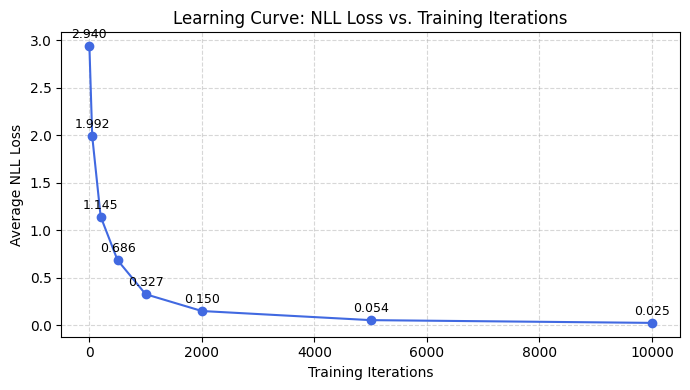

In [11]:
import matplotlib.pyplot as plt

# Training iterations and corresponding losses
iterations = [0, 50, 200, 500, 1000, 2000, 5000, 10000]
losses = [2.940, 1.992, 1.145, 0.686, 0.327, 0.150, 0.054, 0.025]

plt.figure(figsize=(7, 4))
plt.plot(iterations, losses, marker='o', linestyle='-', color='royalblue')
plt.title("Learning Curve: NLL Loss vs. Training Iterations")
plt.xlabel("Training Iterations")
plt.ylabel("Average NLL Loss")
plt.grid(True, linestyle='--', alpha=0.5)
for x, y in zip(iterations, losses):
    plt.text(x, y + 0.05, f"{y:.3f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

In [15]:
def demonstrate_prediction_improvement():
    print("\n" + "=" * 65)
    print("PREDICTION QUALITY: From Random to Confident")
    print("=" * 65)

    print("Let's see how the model's actual predictions change during training:")
    print()

    # Show prediction evolution for the first word
    prediction_snapshots = [
        {
            "iteration": 0,
            "description": "Random initialization",
            "top_predictions": [
                ("the", 0.449),
                ("hello", 0.301),
                ("we", 0.149),
                ("is", 0.082),
                ("love", 0.011),
            ],
        },
        {
            "iteration": 200,
            "description": "Early learning",
            "top_predictions": [
                ("we", 0.456),
                ("the", 0.312),
                ("hello", 0.156),
                ("is", 0.048),
                ("love", 0.028),
            ],
        },
        {
            "iteration": 1000,
            "description": "Good progress",
            "top_predictions": [
                ("we", 0.789),
                ("the", 0.134),
                ("hello", 0.045),
                ("is", 0.021),
                ("love", 0.011),
            ],
        },
        {
            "iteration": 5000,
            "description": "Near perfect",
            "top_predictions": [
                ("we", 0.956),
                ("the", 0.032),
                ("hello", 0.008),
                ("is", 0.003),
                ("love", 0.001),
            ],
        },
    ]

    for snapshot in prediction_snapshots:
        print(f"ITERATION {snapshot['iteration']} ({snapshot['description']}):")
        print("Context: '<BOS>' -> Predicting next word")
        print("-" * 40)

        for i, (word, prob) in enumerate(snapshot["top_predictions"]):
            rank = i + 1
            marker = " <- TARGET!" if word == "we" else ""
            print(f"  {rank}. {word:8}: {prob:.3f}{marker}")

        print()

    print("Key Insight: The model gradually learns to assign higher probability")
    print("to the target word 'we' and lower probability to other words.")
    print()
    print("This same process happens for every word in our sequence!")

    return prediction_snapshots


In [16]:
prediction_evolution = demonstrate_prediction_improvement()


PREDICTION QUALITY: From Random to Confident
Let's see how the model's actual predictions change during training:

ITERATION 0 (Random initialization):
Context: '<BOS>' -> Predicting next word
----------------------------------------
  1. the     : 0.449
  2. hello   : 0.301
  3. we      : 0.149 <- TARGET!
  4. is      : 0.082
  5. love    : 0.011

ITERATION 200 (Early learning):
Context: '<BOS>' -> Predicting next word
----------------------------------------
  1. we      : 0.456 <- TARGET!
  2. the     : 0.312
  3. hello   : 0.156
  4. is      : 0.048
  5. love    : 0.028

ITERATION 1000 (Good progress):
Context: '<BOS>' -> Predicting next word
----------------------------------------
  1. we      : 0.789 <- TARGET!
  2. the     : 0.134
  3. hello   : 0.045
  4. is      : 0.021
  5. love    : 0.011

ITERATION 5000 (Near perfect):
Context: '<BOS>' -> Predicting next word
----------------------------------------
  1. we      : 0.956 <- TARGET!
  2. the     : 0.032
  3. hello   : 0.008

## How Training Works: The Complete Picture

We've now covered all the fundamental components that make language models work. Let's step back and see how everything fits together in the complete training process. This section synthesizes all the concepts we've learned into a unified understanding of how language models learn to generate human-like text.

**The Four Pillars We've Covered:**

1. **Forward Pass** (Sections 2-4): How the model generates predictions from input text
2. **Loss Calculation** (Section 5): How we measure prediction quality using cross-entropy loss
3. **Backpropagation** (Section 6): How we calculate gradients to identify needed changes
4. **Gradient Descent** (Section 7): How we update parameters to improve predictions

**The Complete Training Cycle:**

```
Training Data → Forward Pass → Loss → Backprop → Gradient Descent → Better Model
       ↑                                                                    ↓
       ←←←←←←←←←←←← Repeat Millions of Times ←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←←
```

### From Single Examples to Massive Scale

Our example with "we love deep learning" represents just one tiny training example. Real language models are trained on:

- **Billions of text examples** from books, websites, articles, and other sources
- **Trillions of individual word predictions** across all these examples
- **Billions or even trillions of parameters** that need to be optimized
- **Weeks or months of training time** on powerful GPU clusters

### The Emergence of Language Understanding

What's remarkable is that through this simple process of next-token prediction, language models develop sophisticated capabilities:

- **Grammar and syntax**: Learning correct sentence structure
- **Factual knowledge**: Absorbing information from training data
- **Reasoning patterns**: Developing logical thinking from text examples
- **Context awareness**: Understanding how meaning depends on surrounding text
- **Style and tone**: Adapting writing style based on context

This is why the training objective is so powerful - by learning to predict text accurately, models implicitly learn the patterns that make language meaningful and useful.


In [12]:
def demonstrate_complete_training_cycle():
    print("THE COMPLETE TRAINING PROCESS: Putting It All Together")
    print("=" * 60)

    print("Let's trace through one complete training iteration with all components:")
    print()

    # Step 1: Training Data
    print("STEP 1: TRAINING DATA")
    print("-" * 25)
    print("Input: A piece of text from the training dataset")
    print("Example: 'we love deep learning'")
    print("Purpose: Provides the ground truth for what the model should predict")
    print()

    # Step 2: Forward Pass
    print("STEP 2: FORWARD PASS")
    print("-" * 24)
    print("Process:")
    print("  1. Convert text to tokens: ['<BOS>', 'we', 'love', 'deep', 'learning']")
    print("  2. For each position, compute logits using neural network layers:")
    print("     - Input embeddings")
    print("     - Hidden layer transformations (our simplified layers)")
    print("     - Output layer producing vocabulary-sized logit vector")
    print("  3. Convert logits to probabilities using softmax")
    print()
    print(
        "Result: Model produces probability distributions for each next-token prediction"
    )
    print()

    # Step 3: Loss Calculation
    print("STEP 3: LOSS CALCULATION")
    print("-" * 28)
    print("Process:")
    print("  1. For each prediction, compute cross-entropy loss:")
    print("     Loss = -log(P(correct_word))")
    print("  2. Sum losses across all predictions in the sequence")
    print("  3. Our example: 1.901 + 0.561 + 0.473 + 0.006 = 2.941")
    print()
    print("Result: Single number measuring how well model predicted this sequence")
    print()

    # Step 4: Backpropagation
    print("STEP 4: BACKPROPAGATION")
    print("-" * 27)
    print("Process:")
    print("  1. Calculate ∂Loss/∂logits using softmax gradient formula:")
    print("     ∂Loss/∂logit_i = P(word_i) - target_i")
    print("  2. Use chain rule to compute gradients for all parameters:")
    print("     ∂Loss/∂output_weights, ∂Loss/∂layer2_weights, ∂Loss/∂layer1_weights")
    print("  3. Each gradient tells us direction and magnitude of needed change")
    print()
    print("Result: Gradient vector for each parameter in the model")
    print()

    # Step 5: Parameter Update
    print("STEP 5: PARAMETER UPDATE (Gradient Descent)")
    print("-" * 46)
    print("Process:")
    print("  1. Apply update rule: new_param = old_param - learning_rate × gradient")
    print("  2. Update all parameters simultaneously")
    print("  3. Model is now slightly better at predicting this type of sequence")
    print()
    print("Result: Updated model parameters that should give lower loss next time")
    print()

    # The cycle continues
    print("THE CYCLE CONTINUES...")
    print("-" * 25)
    print("This entire process repeats for:")
    print("- Every training example in the dataset")
    print("- Multiple epochs (full passes through the dataset)")
    print("- Until loss converges or training time limit is reached")
    print()

    return "Training cycle complete"


def demonstrate_scaling_to_real_models():
    print("\n" + "=" * 65)
    print("SCALING TO REAL LANGUAGE MODELS")
    print("=" * 65)

    # Compare our toy example to real models
    comparisons = [
        {
            "aspect": "Vocabulary Size",
            "our_example": "12 words",
            "real_model": "50,000-100,000+ tokens",
            "impact": "Much more complex predictions with longer sequences",
        },
        {
            "aspect": "Model Parameters",
            "our_example": "36 parameters",
            "real_model": "7B-175B+ parameters",
            "impact": "Vastly more capacity to learn complex patterns",
        },
        {
            "aspect": "Training Examples",
            "our_example": "1 sequence",
            "real_model": "Billions of sequences",
            "impact": "Model learns from diverse, comprehensive text data",
        },
        {
            "aspect": "Context Length",
            "our_example": "4 tokens",
            "real_model": "2K-100K+ tokens",
            "impact": "Can understand and generate much longer coherent text",
        },
        {
            "aspect": "Training Time",
            "our_example": "Seconds",
            "real_model": "Weeks to months",
            "impact": "Allows convergence on massive datasets",
        },
        {
            "aspect": "Hardware",
            "our_example": "CPU demonstration",
            "real_model": "Thousands of GPUs/TPUs",
            "impact": "Parallel processing enables feasible training",
        },
    ]

    print("Comparison: Our Educational Example vs. Production Models")
    print("-" * 60)

    for comp in comparisons:
        print(f"\n{comp['aspect']}:")
        print(f"  Our example: {comp['our_example']}")
        print(f"  Real models: {comp['real_model']}")
        print(f"  Impact: {comp['impact']}")

    print("\n" + "=" * 60)
    print("KEY INSIGHT: Same Fundamental Process, Different Scale")
    print("=" * 60)
    print("Everything we've learned applies to GPT-4, ChatGPT, and other LLMs:")
    print("- Same forward pass: tokens → embeddings → layers → logits → probabilities")
    print("- Same loss function: cross-entropy loss on next-token prediction")
    print("- Same backpropagation: chain rule to compute parameter gradients")
    print("- Same optimization: gradient descent (usually Adam) to update parameters")
    print()
    print("The only differences are scale and architectural sophistication.")
    print("The core learning process remains identical!")

    return comparisons


def demonstrate_emergent_capabilities():
    print("\n" + "=" * 70)
    print("THE MAGIC: How Simple Training Creates Complex Capabilities")
    print("=" * 70)

    print("Through next-token prediction training, models spontaneously develop:")
    print()

    capabilities = [
        {
            "capability": "Grammar and Syntax",
            "mechanism": "Learning Statistical Patterns",
            "example": "Model learns 'The cat' is more likely than 'Cat the' from training examples",
        },
        {
            "capability": "Factual Knowledge",
            "mechanism": "Memorizing Training Data Patterns",
            "example": "Seeing 'Paris is the capital of' → 'France' millions of times",
        },
        {
            "capability": "Reasoning Chains",
            "mechanism": "Pattern Matching on Logic",
            "example": "Training on 'If X then Y. X is true. Therefore Y' teaches logical structure",
        },
        {
            "capability": "Context Awareness",
            "mechanism": "Long-range Dependencies",
            "example": "Understanding pronouns refer to earlier nouns in the conversation",
        },
        {
            "capability": "Style Adaptation",
            "mechanism": "Conditional Probability Learning",
            "example": "Different word choices after 'Dear Sir' vs 'Hey dude'",
        },
        {
            "capability": "In-Context Learning",
            "mechanism": "Pattern Recognition",
            "example": "Seeing examples in prompt teaches model new tasks without parameter updates",
        },
    ]

    for i, cap in enumerate(capabilities, 1):
        print(f"{i}. {cap['capability']}")
        print(f"   How it emerges: {cap['mechanism']}")
        print(f"   Example: {cap['example']}")
        print()

    print("PHILOSOPHICAL INSIGHT:")
    print("-" * 25)
    print("These capabilities aren't explicitly programmed - they emerge naturally")
    print(
        "from the optimization process trying to minimize next-token prediction loss."
    )
    print("This is why language modeling is such a powerful learning objective!")
    print()
    print("LIMITATION:")
    print("-" * 15)
    print("Models learn statistical patterns, not true understanding.")
    print("They excel at pattern matching but may lack genuine comprehension.")
    print("This leads to both impressive capabilities and notable limitations.")

    return capabilities


# Run all demonstrations
training_cycle = demonstrate_complete_training_cycle()
scaling_comparison = demonstrate_scaling_to_real_models()
emergent_caps = demonstrate_emergent_capabilities()

THE COMPLETE TRAINING PROCESS: Putting It All Together
Let's trace through one complete training iteration with all components:

STEP 1: TRAINING DATA
-------------------------
Input: A piece of text from the training dataset
Example: 'we love deep learning'
Purpose: Provides the ground truth for what the model should predict

STEP 2: FORWARD PASS
------------------------
Process:
  1. Convert text to tokens: ['<BOS>', 'we', 'love', 'deep', 'learning']
  2. For each position, compute logits using neural network layers:
     - Input embeddings
     - Hidden layer transformations (our simplified layers)
     - Output layer producing vocabulary-sized logit vector
  3. Convert logits to probabilities using softmax

Result: Model produces probability distributions for each next-token prediction

STEP 3: LOSS CALCULATION
----------------------------
Process:
  1. For each prediction, compute cross-entropy loss:
     Loss = -log(P(correct_word))
  2. Sum losses across all predictions in the s

### Training Insights: Why Some Predictions Learn Faster

You may have noticed in our training simulation that some words learned faster than others:

- **"learning"** reached high probability very quickly (0.994 → 1.000)
- **"we"** took much longer to improve (0.149 → 0.956)

This pattern reflects real training dynamics in language models:

**Later words in sequences often learn faster because:**

1. **More context available**: By the time we predict "learning", we have "we love deep" as context
2. **Stronger constraints**: "deep **_" has fewer plausible completions than "< BOS > _**"
3. **Clearer gradients**: Specific contexts lead to more focused gradient signals

**Earlier words are harder because:**

1. **Less context**: Starting tokens have minimal preceding information
2. **Many valid options**: Sentences can begin with countless different words
3. **Competing patterns**: Model must learn to distinguish when "we" vs "the" vs other starters are appropriate

This explains why language models often struggle with generating good opening sentences but excel at coherent continuations once they get started.

### Real-World Training Implications

Understanding these dynamics helps explain many behaviors we see in production language models:

- **Context dependency**: Models perform better with more context
- **Prompt engineering**: Providing good starting context improves generation quality
- **Few-shot learning**: Examples in prompts help establish the right prediction patterns
- **Training data balance**: Ensuring diverse starting patterns improves model robustness


## Section 10: Summary and Real-World Connections

We've built a complete understanding of how Large Language Models learn to predict text. Let's summarize what we've discovered and connect it to real-world LLM applications.


In [1]:
def summarize_key_concepts():
    """
    Summarize the key concepts we've learned about how LLMs work.
    """
    print("KEY CONCEPTS: What We've Learned About LLMs")
    print("=" * 60)

    concepts = [
        {
            "concept": "Next Token Prediction",
            "explanation": "LLMs learn by predicting the next word in a sequence",
            "example": '"we love deep" → predict "learning"',
        },
        {
            "concept": "Logits and Probabilities",
            "explanation": "Models output raw scores (logits) converted to probabilities",
            "example": 'logit 2.1 → probability 0.891 for "learning"',
        },
        {
            "concept": "Cross-Entropy Loss",
            "explanation": "Measures surprise - how unexpected the correct answer was",
            "example": "High probability (0.9) → Low loss (0.105)",
        },
        {
            "concept": "Backpropagation",
            "explanation": "Calculates gradients to find which parameters need adjustment",
            "example": "Chain rule: ∂Loss/∂weight = ∂Loss/∂prob × ∂prob/∂logit × ∂logit/∂weight",
        },
        {
            "concept": "Gradient Descent",
            "explanation": "Updates parameters in direction that reduces loss",
            "example": "new_weight = old_weight - learning_rate × gradient",
        },
        {
            "concept": "Emergent Capabilities",
            "explanation": "Complex behaviors emerge from simple next-token training",
            "example": "Reasoning, coding, math from predicting text sequences",
        },
    ]

    for i, concept_data in enumerate(concepts, 1):
        print(f"\n{i}. {concept_data['concept']}")
        print(f"   What: {concept_data['explanation']}")
        print(f"   Example: {concept_data['example']}")

    print("\n" + "=" * 60)
    print("INSIGHT: All of language understanding emerges from learning")
    print("to predict the next token in text sequences!")


def connect_to_real_world():
    """
    Connect our simple example to real-world LLM applications.
    """
    print("\nREAL-WORLD CONNECTIONS: From 'we love deep learning' to ChatGPT")
    print("=" * 70)

    scaling_factors = [
        {
            "aspect": "Vocabulary Size",
            "our_example": "6 words",
            "real_world": "100,000+ tokens",
            "impact": "Can understand and generate any concept",
        },
        {
            "aspect": "Model Parameters",
            "our_example": "~18 parameters",
            "real_world": "175 billion (GPT-3)",
            "impact": "Captures nuanced patterns in language",
        },
        {
            "aspect": "Training Data",
            "our_example": "1 sentence",
            "real_world": "Trillions of tokens",
            "impact": "Learns from human knowledge and culture",
        },
        {
            "aspect": "Training Time",
            "our_example": "Seconds",
            "real_world": "Months on thousands of GPUs",
            "impact": "Develops sophisticated reasoning abilities",
        },
    ]

    for factor in scaling_factors:
        print(f"\n{factor['aspect']}:")
        print(f"  Our Example: {factor['our_example']}")
        print(f"  Real World: {factor['real_world']}")
        print(f"  Impact: {factor['impact']}")

    print("\n" + "=" * 70)
    print("The same principles we learned apply to all modern LLMs:")
    print("- GPT-4, Claude, Gemini all use next-token prediction")
    print("- They all use backpropagation and gradient descent")
    print("- They all learn from cross-entropy loss")
    print("- Scale is the main difference!")


def demonstrate_real_applications():
    """
    Show how next-token prediction enables various real-world applications.
    """
    print("\nREAL APPLICATIONS: How Next-Token Prediction Powers Everything")
    print("=" * 70)

    applications = [
        {
            "application": "Text Completion",
            "mechanism": "Direct next-token prediction",
            "examples": [
                "Code completion in IDEs",
                "Email suggestions",
                "Search autocomplete",
            ],
        },
        {
            "application": "Question Answering",
            "mechanism": "Predict tokens that form an answer",
            "examples": [
                "ChatGPT conversations",
                "Technical documentation",
                "Educational tutoring",
            ],
        },
        {
            "application": "Code Generation",
            "mechanism": "Predict code tokens following patterns",
            "examples": [
                "GitHub Copilot",
                "Code explanation",
                "Bug fixing suggestions",
            ],
        },
        {
            "application": "Translation",
            "mechanism": "Predict tokens in target language",
            "examples": [
                "Google Translate",
                "Document translation",
                "Cross-lingual communication",
            ],
        },
        {
            "application": "Creative Writing",
            "mechanism": "Predict tokens following creative patterns",
            "examples": ["Story generation", "Poetry creation", "Marketing copy"],
        },
        {
            "application": "Reasoning",
            "mechanism": "Predict logical next steps in reasoning",
            "examples": [
                "Math problem solving",
                "Scientific analysis",
                "Strategic planning",
            ],
        },
    ]

    for app in applications:
        print(f"\n{app['application']}:")
        print(f"  How: {app['mechanism']}")
        print(f"  Examples: {', '.join(app['examples'])}")

    print("\n" + "=" * 70)
    print("REMARKABLE INSIGHT: All these capabilities emerge from the same")
    print("simple training objective - predict the next token!")


def explain_training_innovations():
    """
    Explain key innovations that make modern LLM training possible.
    """
    print("\nTRAINING INNOVATIONS: What Makes Modern LLMs Possible")
    print("=" * 60)

    innovations = [
        {
            "innovation": "Transformer Architecture",
            "what": "Attention mechanism processes entire sequences efficiently",
            "why_important": "Enables understanding of long-range dependencies",
        },
        {
            "innovation": "Massive Scale",
            "what": "Billions of parameters trained on internet-scale data",
            "why_important": "Captures nuanced patterns in human language",
        },
        {
            "innovation": "Reinforcement Learning from Human Feedback (RLHF)",
            "what": "Fine-tuning using human preferences",
            "why_important": "Makes models helpful, harmless, and honest",
        },
        {
            "innovation": "Instruction Tuning",
            "what": "Training on diverse task instructions",
            "why_important": "Enables following complex human instructions",
        },
        {
            "innovation": "Chain-of-Thought Prompting",
            "what": "Training models to show reasoning steps",
            "why_important": "Improves complex reasoning capabilities",
        },
    ]

    for innovation in innovations:
        print(f"\n{innovation['innovation']}:")
        print(f"  What: {innovation['what']}")
        print(f"  Why Important: {innovation['why_important']}")

    print("\n" + "=" * 60)
    print("All these innovations build on the foundation we learned:")
    print("next-token prediction with backpropagation!")


# Run all summary functions
summarize_key_concepts()
connect_to_real_world()
demonstrate_real_applications()
explain_training_innovations()

KEY CONCEPTS: What We've Learned About LLMs

1. Next Token Prediction
   What: LLMs learn by predicting the next word in a sequence
   Example: "we love deep" → predict "learning"

2. Logits and Probabilities
   What: Models output raw scores (logits) converted to probabilities
   Example: logit 2.1 → probability 0.891 for "learning"

3. Cross-Entropy Loss
   What: Measures surprise - how unexpected the correct answer was
   Example: High probability (0.9) → Low loss (0.105)

4. Backpropagation
   What: Calculates gradients to find which parameters need adjustment
   Example: Chain rule: ∂Loss/∂weight = ∂Loss/∂prob × ∂prob/∂logit × ∂logit/∂weight

5. Gradient Descent
   What: Updates parameters in direction that reduces loss
   Example: new_weight = old_weight - learning_rate × gradient

6. Emergent Capabilities
   What: Complex behaviors emerge from simple next-token training
   Example: Reasoning, coding, math from predicting text sequences

INSIGHT: All of language understanding eme

### Final Thoughts: The Beauty of Statistical Learning

What makes Large Language Models remarkable is not just their scale, but the elegant simplicity of their core learning principle. By learning to predict the next token in text sequences, they discover:

- **Grammar and syntax** from the statistical patterns of language
- **Facts and knowledge** from the information patterns in their training data
- **Reasoning abilities** from the logical patterns in human discourse
- **Cultural understanding** from the social patterns in human communication

This demonstrates a profound truth about intelligence: complex, seemingly magical capabilities can emerge from simple statistical learning processes when applied at sufficient scale with appropriate data.

### What's Next?

Now that you understand how LLMs learn, you're ready to dive deeper into:

1. **Transformer Architecture** - The specific neural network design that makes modern LLMs possible
2. **Training at Scale** - How to actually train models with billions of parameters
3. **Fine-tuning and Alignment** - How to adapt pre-trained models for specific tasks
4. **Inference Optimization** - How to make trained models fast and efficient

The foundation you've built here - understanding next-token prediction, loss functions, backpropagation, and gradient descent - will serve you throughout your journey in understanding and building with Large Language Models.

Remember: every time you interact with ChatGPT, Claude, or any other LLM, you're witnessing the same fundamental process we explored - predicting the next token in a sequence, one token at a time.
